In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
import wandb
import time
from wandb.keras import WandbCallback

from __future__ import absolute_import
from __future__ import print_function

import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import plotly.graph_objects as go
import plotly.tools as tls


# from keras.models import Model
# from keras.layers import Input, Flatten, Dense, Dropout, Lambda
# from keras.optimizers import RMSprop
# from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from skimage.transform import resize
from sklearn.manifold import TSNE

In [ ]:
tf.keras.utils.set_random_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
wandb.login(key="204401a4f4dd559f72b4a05d951003a500c49d55")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
num_classes = 268
epochs = 80

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, cattle_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(cattle_indices[d]) for d in range(num_classes)]) - 1
    #print(n)
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = cattle_indices[d][i], cattle_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            random.seed(0) # This ensures repeatibility. For some strange reason, setting this at the beginning doesn't work
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = cattle_indices[d][i], cattle_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input, x)

def bio_metrics(preds, y):
  # Get true positive and true negative indices
  preds = preds.ravel() < 0.5
  tp_idx = np.where((preds==1) & (y==1))
  tn_idx = np.where((preds==0) & (y==0))

  # Get false postive and false negative indices
  fp_idx = np.where((preds==1) & (y==0))
  fn_idx = np.where((preds==0) & (y==1))

  # Get FP, FN, TP, TN
  tp = len(preds[tp_idx])
  fp = len(preds[fp_idx])
  fn = len(preds[fn_idx])
  tn = len(preds[tn_idx])

  # calculate FAR and FRR
  far = fp/(fp+tn)
  frr = fn/(fn+tp)
  return (far, frr)


def compute_accuracy(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < threshold
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# load training data
path = '/content/drive/MyDrive/CapStone/data/NPY_OG_FULL'
train = np.load(f"{path}/train_sch.npy")
labels_train = np.load(f"{path}/labels_train_sch.npy")

In [ ]:
# load validation data
valid = np.load(f"{path}/valid_sch.npy")
labels_valid = np.load(f"{path}/labels_valid_sch.npy")

In [ ]:
# load  datatest
test = np.load(f"{path}/test_sch.npy")
labels_test = np.load(f"{path}/labels_test_sch.npy")

## Transform Train, Valid and Test Images to Grayscale

In [ ]:
# Initialize an empty array for the grayscale images
import cv2
gray_train_images = np.empty((train.shape[0], 50, 50))
gray_valid_images = np.empty((valid.shape[0], 50, 50))
gray_test_images = np.empty((test.shape[0], 50, 50))

# Convert each image to grayscale
for i in range(train.shape[0]):
    gray = cv2.cvtColor(train[i].astype(np.float32), cv2.COLOR_RGB2GRAY)
    gray_train_images[i] = gray

for i in range(valid.shape[0]):
    gray = cv2.cvtColor(valid[i].astype(np.float32), cv2.COLOR_RGB2GRAY)
    gray_valid_images[i] = gray

for i in range(test.shape[0]):
    gray = cv2.cvtColor(test[i].astype(np.float32), cv2.COLOR_RGB2GRAY)
    gray_test_images[i] = gray

train = gray_train_images
valid = gray_valid_images
test = gray_test_images

## Final Preprocessing of Images

In [ ]:
# sort the entire data
idx_train = np.argsort(labels_train)
idx_test = np.argsort(labels_test)
idx_valid = np.argsort(labels_valid)

# sort training set
train = train[idx_train]
labels_train = labels_train[idx_train]
test = test[idx_test]
labels_test = labels_test[idx_test]
valid = valid[idx_valid]
labels_valid = labels_valid[idx_valid]

In [ ]:
train = train.astype('float32')
valid = valid.astype('float32')
train /= 255
valid /= 255
test = test/255
input_shape = train.shape[1:]

In [ ]:
# Define unique
unique = np.unique(labels_train)

## Define Hyperparams

In [ ]:
config = {
    "batch_size": 32, # restore to 4 later
    "optimizer": "RMSProp"
}

In [ ]:
run  = wandb.init(
    # set the wandb project where this run will be logged
    name = "final-25",
    project="capstone-scalability",
    reinit = True,

    # track hyperparameters and run metadata
    config=config
)

wandb: Currently logged in as: lnkama (dl-cmu). Use `wandb login --relogin` to force relogin


## Time History Callback

In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## Train on 25 Classes

In [ ]:
idx_train = np.where(np.in1d(labels_train, unique[:25]))
idx_valid = np.where(np.in1d(labels_valid, unique[:25]))
idx_test = np.where(np.in1d(labels_test, unique[:25]))

x_train = train.copy()[idx_train]
y_train = labels_train.copy()[idx_train]
x_valid = valid.copy()[idx_valid]
y_valid = labels_valid.copy()[idx_valid]
x_test = test.copy()[idx_test]
y_test = labels_test.copy()[idx_test]

In [ ]:
# create training+test positive and negative pairs
cattle_indices = [np.where(y_train == i)[0] for i in unique[:25]]
tr_pairs, tr_y = create_pairs(x_train, cattle_indices, 25)
cattle_indices = [np.where(y_valid == i)[0] for i in unique[:25]]
tv_pairs, tv_y = create_pairs(x_valid, cattle_indices, 25)
tv_pairs.shape

(350, 2, 50, 50)

In [ ]:
checkpoint = ModelCheckpoint('model-best25.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callback = TimeHistory()


# Add the checkpoint to the list of callbacks
callbacks_list = [checkpoint, WandbCallback(save_model=True), time_callback]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y.astype(np.float32), # why float32
          batch_size=config["batch_size"], # original is 128
          epochs=epochs,
          validation_data=([tv_pairs[:, 0], tv_pairs[:, 1]], tv_y.astype(np.float32)), callbacks=callbacks_list) # why float32



# compute final accuracy on training and validation sets using the best model
model = load_model('model-best25.h5', custom_objects={'contrastive_loss': contrastive_loss })
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_tv = model.predict([tv_pairs[:, 0], tv_pairs[:, 1]])
tv_acc = compute_accuracy(tv_y, y_pred_tv)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on val set: %0.2f%%' % (100 * tv_acc))

Epoch 1/80
41/47 [=========================>....] - ETA: 0s - loss: 0.2439 - accuracy: 0.5587
Epoch 1: val_loss improved from inf to 0.19481, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 4s 50ms/step - loss: 0.2381 - accuracy: 0.5836 - val_loss: 0.1948 - val_accuracy: 0.7133
Epoch 2/80
40/47 [========================>.....] - ETA: 0s - loss: 0.1653 - accuracy: 0.7727
Epoch 2: val_loss improved from 0.19481 to 0.16592, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 48ms/step - loss: 0.1622 - accuracy: 0.7822 - val_loss: 0.1659 - val_accuracy: 0.7506
Epoch 3/80
38/47 [=======================>......] - ETA: 0s - loss: 0.1394 - accuracy: 0.8117
Epoch 3: val_loss improved from 0.16592 to 0.11484, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 40ms/step - loss: 0.1375 - accuracy: 0.8149 - val_loss: 0.1148 - val_accuracy: 0.8358
Epoch 4/80
39/47 [=======================>......] - ETA: 0s - loss: 0.1227 - accuracy: 0.8309
Epoch 4: val_loss did not improve from 0.11484
47/47 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.8409 - val_loss: 0.2546 - val_accuracy: 0.6481
Epoch 5/80
40/47 [========================>.....] - ETA: 0s - loss: 0.1036 - accuracy: 0.8656
Epoch 5: val_loss improved from 0.11484 to 0.08833, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 40ms/step - loss: 0.0986 - accuracy: 0.8702 - val_loss: 0.0883 - val_accuracy: 0.8814
Epoch 6/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0890 - accuracy: 0.8948
Epoch 6: val_loss did not improve from 0.08833
47/47 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.8920 - val_loss: 0.1369 - val_accuracy: 0.7930
Epoch 7/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0803 - accuracy: 0.9054
Epoch 7: val_loss improved from 0.08833 to 0.08047, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 41ms/step - loss: 0.0866 - accuracy: 0.8953 - val_loss: 0.0805 - val_accuracy: 0.9254
Epoch 8/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9116
Epoch 8: val_loss did not improve from 0.08047
47/47 [==============================] - 0s 6ms/step - loss: 0.0734 - accuracy: 0.9125 - val_loss: 0.1772 - val_accuracy: 0.7280
Epoch 9/80
42/47 [=========================>....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9115
Epoch 9: val_loss improved from 0.08047 to 0.05977, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 40ms/step - loss: 0.0703 - accuracy: 0.9188 - val_loss: 0.0598 - val_accuracy: 0.9311
Epoch 10/80
47/47 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9188
Epoch 10: val_loss did not improve from 0.05977
47/47 [==============================] - 0s 7ms/step - loss: 0.0658 - accuracy: 0.9188 - val_loss: 0.1086 - val_accuracy: 0.8653
Epoch 11/80
46/47 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9341
Epoch 11: val_loss improved from 0.05977 to 0.04919, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 42ms/step - loss: 0.0629 - accuracy: 0.9347 - val_loss: 0.0492 - val_accuracy: 0.9509
Epoch 12/80
47/47 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9515
Epoch 12: val_loss did not improve from 0.04919
47/47 [==============================] - 0s 7ms/step - loss: 0.0471 - accuracy: 0.9515 - val_loss: 0.0574 - val_accuracy: 0.9375
Epoch 13/80
40/47 [========================>.....] - ETA: 0s - loss: 0.0500 - accuracy: 0.9453
Epoch 13: val_loss did not improve from 0.04919
47/47 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.9446 - val_loss: 0.0580 - val_accuracy: 0.9430
Epoch 14/80
40/47 [========================>.....] - ETA: 0s - loss: 0.0371 - accuracy: 0.9617
Epoch 14: val_loss did not improve from 0.04919
47/47 [==============================] - 0s 7ms/step - loss: 0.0377 - accuracy: 0.9634 - val_loss: 0.0755 - val_accuracy: 0.9049
Epoch 15/80
40/47 [========================>.....] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 52ms/step - loss: 0.0289 - accuracy: 0.9727 - val_loss: 0.0482 - val_accuracy: 0.9432
Epoch 21/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0334 - accuracy: 0.9665
Epoch 21: val_loss improved from 0.04818 to 0.04190, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 39ms/step - loss: 0.0340 - accuracy: 0.9654 - val_loss: 0.0419 - val_accuracy: 0.9574
Epoch 22/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0281 - accuracy: 0.9704
Epoch 22: val_loss did not improve from 0.04190
47/47 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9740 - val_loss: 0.0767 - val_accuracy: 0.9085
Epoch 23/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0291 - accuracy: 0.9718
Epoch 23: val_loss did not improve from 0.04190
47/47 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9754 - val_loss: 0.0439 - val_accuracy: 0.9517
Epoch 24/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0310 - accuracy: 0.9703
Epoch 24: val_loss did not improve from 0.04190
47/47 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9721 - val_loss: 0.0475 - val_accuracy: 0.9545
Epoch 25/80
41/47 [=========================>....] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 40ms/step - loss: 0.0261 - accuracy: 0.9746 - val_loss: 0.0387 - val_accuracy: 0.9631
Epoch 26/80
43/47 [==========================>...] - ETA: 0s - loss: 0.0229 - accuracy: 0.9782
Epoch 26: val_loss did not improve from 0.03870
47/47 [==============================] - 0s 6ms/step - loss: 0.0246 - accuracy: 0.9765 - val_loss: 0.1725 - val_accuracy: 0.7733
Epoch 27/80
40/47 [========================>.....] - ETA: 0s - loss: 0.0345 - accuracy: 0.9633
Epoch 27: val_loss did not improve from 0.03870
47/47 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9680 - val_loss: 0.0409 - val_accuracy: 0.9545
Epoch 28/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0184 - accuracy: 0.9855
Epoch 28: val_loss improved from 0.03870 to 0.03782, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 42ms/step - loss: 0.0204 - accuracy: 0.9820 - val_loss: 0.0378 - val_accuracy: 0.9659
Epoch 29/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0215 - accuracy: 0.9784
Epoch 29: val_loss did not improve from 0.03782
47/47 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9699 - val_loss: 0.0496 - val_accuracy: 0.9430
Epoch 30/80
47/47 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9827
Epoch 30: val_loss did not improve from 0.03782
47/47 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.9827 - val_loss: 0.0379 - val_accuracy: 0.9659
Epoch 31/80
47/47 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9839
Epoch 31: val_loss improved from 0.03782 to 0.03488, saving model to model-best25.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 40ms/step - loss: 0.0175 - accuracy: 0.9839 - val_loss: 0.0349 - val_accuracy: 0.9659
Epoch 32/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0239 - accuracy: 0.9733
Epoch 32: val_loss did not improve from 0.03488
47/47 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9712 - val_loss: 0.0422 - val_accuracy: 0.9489
Epoch 33/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0163 - accuracy: 0.9840
Epoch 33: val_loss did not improve from 0.03488
47/47 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9844 - val_loss: 0.1325 - val_accuracy: 0.7879
Epoch 34/80
40/47 [========================>.....] - ETA: 0s - loss: 0.0265 - accuracy: 0.9680
Epoch 34: val_loss did not improve from 0.03488
47/47 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9674 - val_loss: 0.0500 - val_accuracy: 0.9403
Epoch 35/80
41/47 [=========================>....] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 41ms/step - loss: 0.0159 - accuracy: 0.9867 - val_loss: 0.0348 - val_accuracy: 0.9602
Epoch 39/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0212 - accuracy: 0.9809
Epoch 39: val_loss did not improve from 0.03475
47/47 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.9834 - val_loss: 0.0377 - val_accuracy: 0.9460
Epoch 40/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0143 - accuracy: 0.9864
Epoch 40: val_loss did not improve from 0.03475
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 0.9867 - val_loss: 0.0589 - val_accuracy: 0.9402
Epoch 41/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0164 - accuracy: 0.9840
Epoch 41: val_loss did not improve from 0.03475
47/47 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9854 - val_loss: 0.0395 - val_accuracy: 0.9686
Epoch 42/80
38/47 [=======================>......] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 43ms/step - loss: 0.0183 - accuracy: 0.9807 - val_loss: 0.0326 - val_accuracy: 0.9659
Epoch 48/80
46/47 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9857
Epoch 48: val_loss did not improve from 0.03259
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - accuracy: 0.9853 - val_loss: 0.0557 - val_accuracy: 0.9460
Epoch 49/80
47/47 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9867
Epoch 49: val_loss did not improve from 0.03259
47/47 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9867 - val_loss: 0.0371 - val_accuracy: 0.9659
Epoch 50/80
40/47 [========================>.....] - ETA: 0s - loss: 0.0139 - accuracy: 0.9867
Epoch 50: val_loss did not improve from 0.03259
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 0.9880 - val_loss: 0.0490 - val_accuracy: 0.9375
Epoch 51/80
40/47 [========================>.....] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 40ms/step - loss: 0.0084 - accuracy: 0.9920 - val_loss: 0.0299 - val_accuracy: 0.9629
Epoch 72/80
42/47 [=========================>....] - ETA: 0s - loss: 0.0152 - accuracy: 0.9821
Epoch 72: val_loss did not improve from 0.02990
47/47 [==============================] - 0s 6ms/step - loss: 0.0142 - accuracy: 0.9833 - val_loss: 0.0370 - val_accuracy: 0.9659
Epoch 73/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - accuracy: 0.9954
Epoch 73: val_loss did not improve from 0.02990
47/47 [==============================] - 0s 7ms/step - loss: 0.0039 - accuracy: 0.9960 - val_loss: 0.0340 - val_accuracy: 0.9631
Epoch 74/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0124 - accuracy: 0.9864
Epoch 74: val_loss did not improve from 0.02990
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - accuracy: 0.9874 - val_loss: 0.0447 - val_accuracy: 0.9375
Epoch 75/80
41/47 [=========================>....] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011438-5uuu7bya/files/model-best)... Done. 0.0s


47/47 [==============================] - 2s 52ms/step - loss: 0.0092 - accuracy: 0.9920 - val_loss: 0.0253 - val_accuracy: 0.9716
Epoch 76/80
42/47 [=========================>....] - ETA: 0s - loss: 0.0187 - accuracy: 0.9769
Epoch 76: val_loss did not improve from 0.02526
47/47 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9780 - val_loss: 0.0787 - val_accuracy: 0.9174
Epoch 77/80
39/47 [=======================>......] - ETA: 0s - loss: 0.0173 - accuracy: 0.9776
Epoch 77: val_loss did not improve from 0.02526
47/47 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9807 - val_loss: 0.0484 - val_accuracy: 0.9460
Epoch 78/80
41/47 [=========================>....] - ETA: 0s - loss: 0.0370 - accuracy: 0.9588
Epoch 78: val_loss did not improve from 0.02526
47/47 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9621 - val_loss: 0.0412 - val_accuracy: 0.9487
Epoch 79/80
41/47 [=========================>....] - E

In [ ]:
times_epoch = time_callback.times
wandb.log({f'Average Training time per epoch (25)': round(np.mean(times_epoch),4)})

In [ ]:
new_classes = [25, 50, 100, 125, 150, 180, 200, 210, 220, 230, 250, 268] # test set of classes to consider
acc_scale25 = []
fars_25 = []
frrs_25  = []

for i in new_classes:
  idx_test_scale = np.where(np.in1d(labels_test, unique[:i]))
  scale_ytest = labels_test.copy()[idx_test_scale]
  scale_xtest = test.copy()[idx_test_scale]
  cattle_indices = [np.where(scale_ytest == i)[0] for i in unique[:i]]
  te_pairs, te_y = create_pairs(scale_xtest, cattle_indices, i)
  pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  far, frr = bio_metrics(pred_te, te_y)
  fars_25.append(far)
  frrs_25.append(frr)
  comp_acc = compute_accuracy(te_y, pred_te)
  acc_scale25.append(comp_acc)

67/67 [==============================] - 0s 2ms/step


In [ ]:
# log accuracies for training on 25 classes
acc_tab = {'Test Accuracy': acc_scale25, 'Number of Classes': new_classes, 'Training Accuracy': tr_acc,\
           'Training time per epoch (seconds)': round(np.mean(times_epoch), 4)}
acc_tab = pd.DataFrame(acc_tab)
wandb.log({"Scaling Metrics for Training on 25 classes": wandb.Table(data=acc_tab, columns = \
["Test Accuracy", "Number of Classes", "Training Accuracy", 'Training time per epoch (seconds)'])})

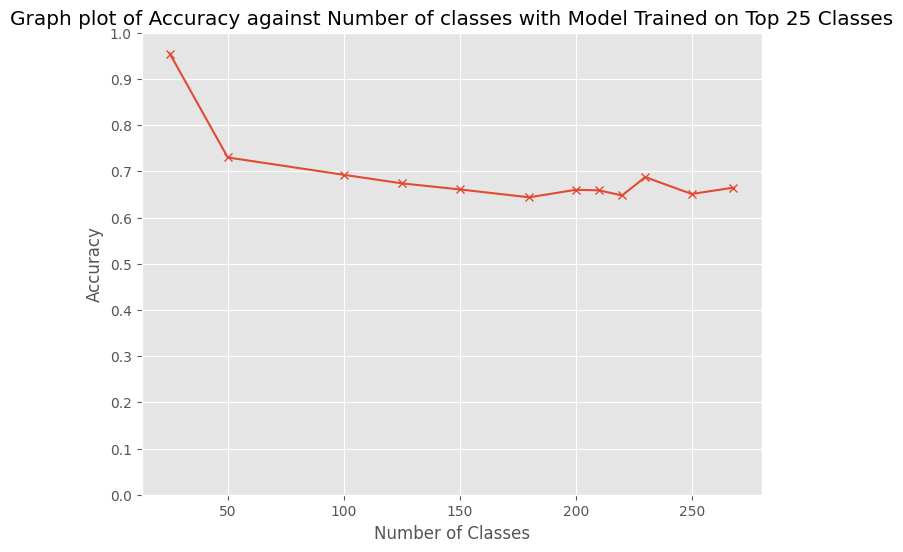

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, acc_scale25, marker='x')
ax.set_title("Graph plot of Accuracy against Number of classes with Model Trained on Top 25 Classes")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Classes')
ax.yaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_ylim(bottom=0)
plt.show()

In [ ]:
wandb.log({"Plot of Accuracy against Number of classes with Model Trained on Top 25 Classes": fig})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



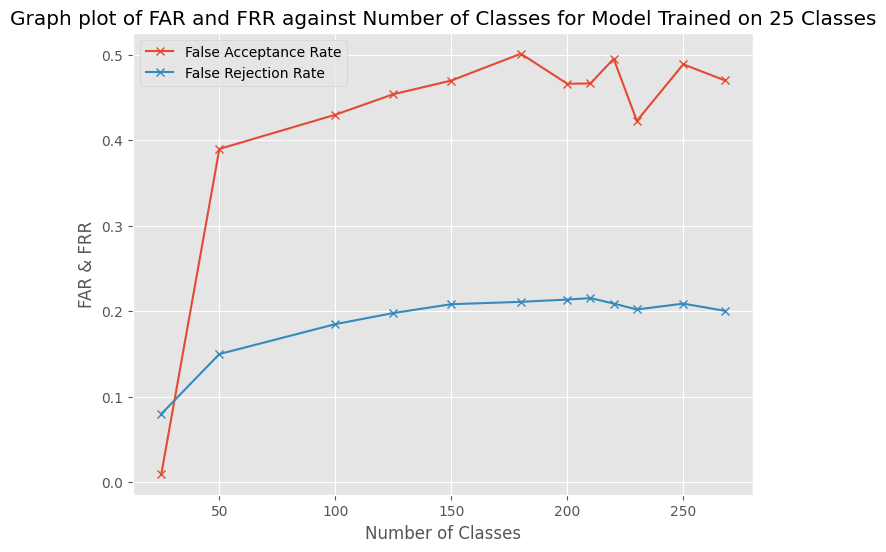

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, fars_25, label = 'False Acceptance Rate', marker = 'x')
ax.plot(new_classes, frrs_25, label = 'False Rejection Rate', marker = 'x')
ax.set_title("Graph plot of FAR and FRR against Number of Classes for Model Trained on 25 Classes")
ax.set_xlabel('Number of Classes')
ax.set_ylabel('FAR & FRR')
ax.legend()
plt.show()

In [ ]:
wandb.log({"FAR/FRR Metrics": wandb.Image(fig)})

## Train on 50 Classes

In [ ]:
idx_train = np.where(np.in1d(labels_train, unique[:50]))
idx_valid = np.where(np.in1d(labels_valid, unique[:50]))
idx_test = np.where(np.in1d(labels_test, unique[:50]))

x_train = train.copy()[idx_train]
y_train = labels_train.copy()[idx_train]
x_valid = valid.copy()[idx_valid]
y_valid = labels_valid.copy()[idx_valid]
x_test = test.copy()[idx_test]
y_test = labels_test.copy()[idx_test]

In [ ]:
# create training+test positive and negative pairs
cattle_indices = [np.where(y_train == i)[0] for i in unique[:50]]
tr_pairs, tr_y = create_pairs(x_train, cattle_indices, 50)
cattle_indices = [np.where(y_valid == i)[0] for i in unique[:50]]
tv_pairs, tv_y = create_pairs(x_valid, cattle_indices, 50)
tv_pairs.shape

(700, 2, 50, 50)

In [ ]:
# cattle_indices = [np.where(y_test == i)[0] for i in unique[:50]]
# te_pairs, te_y = create_pairs(x_test, cattle_indices)
# te_pairs.shape

In [ ]:
tr_pairs.shape

(3000, 2, 50, 50)

In [ ]:
run  = wandb.init(
    # set the wandb project where this run will be logged
    name = "final-50",
    project="capstone-scalability",
    reinit = True,

    # track hyperparameters and run metadata
    config=config
)

Average Training time per epoch (25),▁
accuracy,▁▅▆▆▇▇▇▇█▇▇█████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇▄▇█▇██▇█▃▆▇▇█▄▆██▇▇▇▇▇█▆▇█▇███▇█
val_loss,█▅▄▃▂▂▂▂▅▃▂▂▂▂▂▁▅▃▁▂▂▆▃▁▁▃▁▂▂▂▂▄▃▂▂▁▁▁▂▂
Average Training time per epoch (25),0.6721
accuracy,0.97407
best_epoch,74
best_val_loss,0.02526
epoch,79


In [ ]:
checkpoint = ModelCheckpoint('model-best50.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callback = TimeHistory()
# Add the checkpoint to the list of callbacks
callbacks_list = [checkpoint, WandbCallback(save_model=True), time_callback]

In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y.astype(np.float32), # why float32
          batch_size=config["batch_size"], # original is 128
          epochs=epochs,
          validation_data=([tv_pairs[:, 0], tv_pairs[:, 1]], tv_y.astype(np.float32)), callbacks=callbacks_list) # why float32



# compute final accuracy on training and validation sets using the best model
model = load_model('model-best50.h5', custom_objects={'contrastive_loss': contrastive_loss, })
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_tv = model.predict([tv_pairs[:, 0], tv_pairs[:, 1]])
tv_acc = compute_accuracy(tv_y, y_pred_tv)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on val set: %0.2f%%' % (100 * tv_acc))

Epoch 1/80
94/94 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.6135
Epoch 1: val_loss improved from inf to 0.19377, saving model to model-best50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 3s 24ms/step - loss: 0.2256 - accuracy: 0.6135 - val_loss: 0.1938 - val_accuracy: 0.6644
Epoch 2/80
93/94 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.8243
Epoch 2: val_loss improved from 0.19377 to 0.07544, saving model to model-best50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 23ms/step - loss: 0.1382 - accuracy: 0.8248 - val_loss: 0.0754 - val_accuracy: 0.9142
Epoch 3/80
89/94 [===========================>..] - ETA: 0s - loss: 0.1019 - accuracy: 0.8824
Epoch 3: val_loss did not improve from 0.07544
94/94 [==============================] - 1s 6ms/step - loss: 0.1014 - accuracy: 0.8838 - val_loss: 0.1091 - val_accuracy: 0.8352
Epoch 4/80
90/94 [===========================>..] - ETA: 0s - loss: 0.0826 - accuracy: 0.9069
Epoch 4: val_loss did not improve from 0.07544
94/94 [==============================] - 1s 6ms/step - loss: 0.0819 - accuracy: 0.9082 - val_loss: 0.0766 - val_accuracy: 0.9044
Epoch 5/80
87/94 [==========================>...] - ETA: 0s - loss: 0.0688 - accuracy: 0.9328
Epoch 5: val_loss improved from 0.07544 to 0.07393, saving model to model-best50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 23ms/step - loss: 0.0667 - accuracy: 0.9367 - val_loss: 0.0739 - val_accuracy: 0.9056
Epoch 6/80
87/94 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9440
Epoch 6: val_loss did not improve from 0.07393
94/94 [==============================] - 1s 7ms/step - loss: 0.0602 - accuracy: 0.9445 - val_loss: 0.0807 - val_accuracy: 0.8886
Epoch 7/80
94/94 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9473
Epoch 7: val_loss did not improve from 0.07393
94/94 [==============================] - 1s 7ms/step - loss: 0.0551 - accuracy: 0.9473 - val_loss: 0.0858 - val_accuracy: 0.9087
Epoch 8/80
94/94 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9517
Epoch 8: val_loss improved from 0.07393 to 0.04115, saving model to model-best50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 3s 28ms/step - loss: 0.0497 - accuracy: 0.9517 - val_loss: 0.0411 - val_accuracy: 0.9631
Epoch 9/80
88/94 [===========================>..] - ETA: 0s - loss: 0.0455 - accuracy: 0.9588
Epoch 9: val_loss did not improve from 0.04115
94/94 [==============================] - 1s 6ms/step - loss: 0.0443 - accuracy: 0.9600 - val_loss: 0.0459 - val_accuracy: 0.9474
Epoch 10/80
90/94 [===========================>..] - ETA: 0s - loss: 0.0443 - accuracy: 0.9622
Epoch 10: val_loss did not improve from 0.04115
94/94 [==============================] - 1s 6ms/step - loss: 0.0459 - accuracy: 0.9579 - val_loss: 0.0487 - val_accuracy: 0.9416
Epoch 11/80
91/94 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9698
Epoch 11: val_loss did not improve from 0.04115
94/94 [==============================] - 1s 6ms/step - loss: 0.0377 - accuracy: 0.9704 - val_loss: 0.0454 - val_accuracy: 0.9454
Epoch 12/80
90/94 [===========================>..] - ETA

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 23ms/step - loss: 0.0321 - accuracy: 0.9727 - val_loss: 0.0297 - val_accuracy: 0.9673
Epoch 16/80
91/94 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9811
Epoch 16: val_loss did not improve from 0.02966
94/94 [==============================] - 1s 6ms/step - loss: 0.0273 - accuracy: 0.9804 - val_loss: 0.0643 - val_accuracy: 0.9227
Epoch 17/80
91/94 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9797
Epoch 17: val_loss did not improve from 0.02966
94/94 [==============================] - 1s 6ms/step - loss: 0.0262 - accuracy: 0.9799 - val_loss: 0.0463 - val_accuracy: 0.9385
Epoch 18/80
91/94 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9825
Epoch 18: val_loss did not improve from 0.02966
94/94 [==============================] - 1s 6ms/step - loss: 0.0233 - accuracy: 0.9827 - val_loss: 0.0326 - val_accuracy: 0.9645
Epoch 19/80
90/94 [===========================>..] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 23ms/step - loss: 0.0226 - accuracy: 0.9847 - val_loss: 0.0279 - val_accuracy: 0.9673
Epoch 21/80
87/94 [==========================>...] - ETA: 0s - loss: 0.0223 - accuracy: 0.9813
Epoch 21: val_loss did not improve from 0.02788
94/94 [==============================] - 1s 6ms/step - loss: 0.0224 - accuracy: 0.9816 - val_loss: 0.0518 - val_accuracy: 0.9414
Epoch 22/80
94/94 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9826
Epoch 22: val_loss did not improve from 0.02788
94/94 [==============================] - 1s 7ms/step - loss: 0.0221 - accuracy: 0.9826 - val_loss: 0.0310 - val_accuracy: 0.9631
Epoch 23/80
86/94 [==========================>...] - ETA: 0s - loss: 0.0198 - accuracy: 0.9866
Epoch 23: val_loss improved from 0.02788 to 0.02615, saving model to model-best50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 23ms/step - loss: 0.0192 - accuracy: 0.9867 - val_loss: 0.0262 - val_accuracy: 0.9696
Epoch 24/80
86/94 [==========================>...] - ETA: 0s - loss: 0.0191 - accuracy: 0.9876
Epoch 24: val_loss did not improve from 0.02615
94/94 [==============================] - 1s 6ms/step - loss: 0.0186 - accuracy: 0.9880 - val_loss: 0.0416 - val_accuracy: 0.9397
Epoch 25/80
87/94 [==========================>...] - ETA: 0s - loss: 0.0181 - accuracy: 0.9864
Epoch 25: val_loss did not improve from 0.02615
94/94 [==============================] - 1s 6ms/step - loss: 0.0174 - accuracy: 0.9874 - val_loss: 0.0309 - val_accuracy: 0.9511
Epoch 26/80
90/94 [===========================>..] - ETA: 0s - loss: 0.0170 - accuracy: 0.9854
Epoch 26: val_loss did not improve from 0.02615
94/94 [==============================] - 1s 6ms/step - loss: 0.0173 - accuracy: 0.9854 - val_loss: 0.0268 - val_accuracy: 0.9716
Epoch 27/80
92/94 [============================>.] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 24ms/step - loss: 0.0153 - accuracy: 0.9855 - val_loss: 0.0241 - val_accuracy: 0.9683
Epoch 32/80
92/94 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9922
Epoch 32: val_loss did not improve from 0.02410
94/94 [==============================] - 1s 6ms/step - loss: 0.0123 - accuracy: 0.9920 - val_loss: 0.0993 - val_accuracy: 0.8770
Epoch 33/80
91/94 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9863
Epoch 33: val_loss did not improve from 0.02410
94/94 [==============================] - 1s 6ms/step - loss: 0.0150 - accuracy: 0.9863 - val_loss: 0.0515 - val_accuracy: 0.9298
Epoch 34/80
94/94 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9867
Epoch 34: val_loss did not improve from 0.02410
94/94 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9867 - val_loss: 0.0307 - val_accuracy: 0.9568
Epoch 35/80
93/94 [============================>.] - E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 23ms/step - loss: 0.0146 - accuracy: 0.9880 - val_loss: 0.0232 - val_accuracy: 0.9696
Epoch 36/80
94/94 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9910
Epoch 36: val_loss improved from 0.02319 to 0.02003, saving model to model-best50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011545-j6bidw6e/files/model-best)... Done. 0.0s


94/94 [==============================] - 2s 22ms/step - loss: 0.0124 - accuracy: 0.9910 - val_loss: 0.0200 - val_accuracy: 0.9759
Epoch 37/80
89/94 [===========================>..] - ETA: 0s - loss: 0.0115 - accuracy: 0.9884
Epoch 37: val_loss did not improve from 0.02003
94/94 [==============================] - 1s 6ms/step - loss: 0.0114 - accuracy: 0.9886 - val_loss: 0.0385 - val_accuracy: 0.9432
Epoch 38/80
94/94 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9930
Epoch 38: val_loss did not improve from 0.02003
94/94 [==============================] - 1s 7ms/step - loss: 0.0105 - accuracy: 0.9930 - val_loss: 0.0514 - val_accuracy: 0.9314
Epoch 39/80
94/94 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9907
Epoch 39: val_loss did not improve from 0.02003
94/94 [==============================] - 1s 7ms/step - loss: 0.0114 - accuracy: 0.9907 - val_loss: 0.0272 - val_accuracy: 0.9659
Epoch 40/80
87/94 [==========================>...] - E

In [ ]:
times_epoch = time_callback.times
wandb.log({f'Average Training time per epoch (50)': round(np.mean(times_epoch),4)})

In [ ]:
new_classes = [50, 100, 125, 150, 180, 200, 210, 220, 230, 250, 268]# test set of classes to consider
acc_scale50 = []
fars_50 = []
frrs_50 = []

for i in new_classes:
  idx_test_scale = np.where(np.in1d(labels_test, unique[:i]))
  scale_ytest = labels_test.copy()[idx_test_scale]
  scale_xtest = test.copy()[idx_test_scale]
  cattle_indices = [np.where(scale_ytest == i)[0] for i in unique[:i]]
  te_pairs, te_y = create_pairs(scale_xtest, cattle_indices, i)
  pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  far, frr = bio_metrics(pred_te, te_y)
  fars_50.append(far)
  frrs_50.append(frr)
  comp_acc = compute_accuracy(te_y, pred_te)
  acc_scale50.append(comp_acc)

67/67 [==============================] - 0s 2ms/step


In [ ]:
# log accuracies for training on 50 classes
acc_tab = {'Test Accuracy': acc_scale50, 'Number of Classes': new_classes, 'Training Accuracy': tr_acc,\
           'Training time per epoch (seconds)': round(np.mean(times_epoch), 4)}
acc_tab = pd.DataFrame(acc_tab)
wandb.log({"Scaling Metrics for Training on 50 classes": wandb.Table(data=acc_tab, columns = \
["Test Accuracy", "Number of Classes", "Training Accuracy", 'Training time per epoch (seconds)'])})

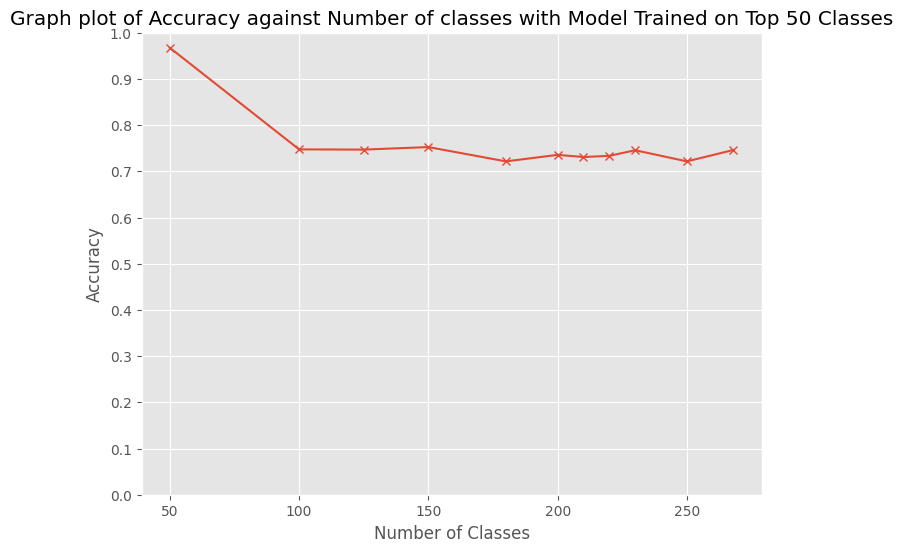

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, acc_scale50, marker='x')
ax.set_title("Graph plot of Accuracy against Number of classes with Model Trained on Top 50 Classes")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Classes')
ax.yaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_ylim(bottom=0)
plt.show()

In [ ]:
wandb.log({"Plot of Accuracy against Number of classes with Model Trained on Top 50 Classes": fig})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



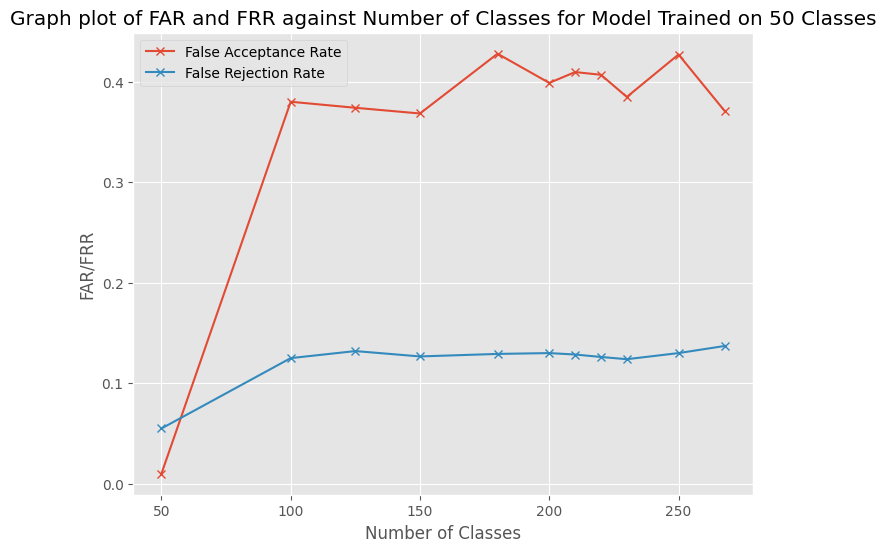

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, fars_50, label = 'False Acceptance Rate', marker='x')
ax.plot(new_classes, frrs_50, label = 'False Rejection Rate', marker='x')
ax.set_title("Graph plot of FAR and FRR against Number of Classes for Model Trained on 50 Classes")
ax.set_xlabel('Number of Classes')
ax.set_ylabel('FAR/FRR')
ax.legend()
plt.show()

In [ ]:
wandb.log({"FAR/FRR Metrics": wandb.Image(fig)})

## Train on 100 Classes

In [ ]:
idx_train = np.where(np.in1d(labels_train, unique[:100]))
idx_valid = np.where(np.in1d(labels_valid, unique[:100]))
idx_test = np.where(np.in1d(labels_test, unique[:100]))

x_train = train.copy()[idx_train]
y_train = labels_train.copy()[idx_train]
x_valid = valid.copy()[idx_valid]
y_valid = labels_valid.copy()[idx_valid]
x_test = test.copy()[idx_test]
y_test = labels_test.copy()[idx_test]


In [ ]:
# create training+test positive and negative pairs
cattle_indices = [np.where(y_train == i)[0] for i in unique[:100]]
tr_pairs, tr_y = create_pairs(x_train, cattle_indices, 100)
cattle_indices = [np.where(y_valid == i)[0] for i in unique[:100]]
tv_pairs, tv_y = create_pairs(x_valid, cattle_indices, 100)
tv_pairs.shape

(1400, 2, 50, 50)

In [ ]:
run  = wandb.init(
    # set the wandb project where this run will be logged
    name = "final-100",
    project="capstone-scalability",
    reinit = True,

    # track hyperparameters and run metadata
    config=config
)

Average Training time per epoch (50),▁
accuracy,▁▆▇▇▇███████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇▇▇█▇▇▇█████▇█▇███▇██▇███▇██▆▅▅██▇██
val_loss,█▅▃▄▂▂▃▁▂▃▂▁▁▁▁▁▂▁▂▁▁▁▂▂▁▂▁▁▁▂▁▁▃▅▄▂▂▂▁▂
Average Training time per epoch (50),0.8017
accuracy,0.97773
best_epoch,35
best_val_loss,0.02003
epoch,79


In [ ]:
checkpoint = ModelCheckpoint('model-best100.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callback = TimeHistory()

# Add the checkpoint to the list of callbacks
callbacks_list = [checkpoint, WandbCallback(save_model=True), time_callback]

In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model_100 = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model_100.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model_100.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y.astype(np.float32), # why float32
          batch_size=config["batch_size"], # original is 128
          epochs=epochs,
          validation_data=([tv_pairs[:, 0], tv_pairs[:, 1]], tv_y.astype(np.float32)), callbacks=callbacks_list) # why float32


# compute final accuracy on training and validation sets using the best model
model= load_model('model-best100.h5', custom_objects={'contrastive_loss': contrastive_loss, })
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_tv = model.predict([tv_pairs[:, 0], tv_pairs[:, 1]])
tv_acc = compute_accuracy(tv_y, y_pred_tv)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on val set: %0.2f%%' % (100 * tv_acc))

Epoch 1/80
179/188 [===========================>..] - ETA: 0s - loss: 0.2590 - accuracy: 0.5028
Epoch 1: val_loss improved from inf to 0.34016, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 4s 16ms/step - loss: 0.2590 - accuracy: 0.5038 - val_loss: 0.3402 - val_accuracy: 0.5111
Epoch 2/80
187/188 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.7012
Epoch 2: val_loss improved from 0.34016 to 0.12876, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 15ms/step - loss: 0.1932 - accuracy: 0.7018 - val_loss: 0.1288 - val_accuracy: 0.8215
Epoch 3/80
179/188 [===========================>..] - ETA: 0s - loss: 0.1430 - accuracy: 0.8088
Epoch 3: val_loss improved from 0.12876 to 0.10503, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 14ms/step - loss: 0.1419 - accuracy: 0.8098 - val_loss: 0.1050 - val_accuracy: 0.8606
Epoch 4/80
186/188 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.8515
Epoch 4: val_loss did not improve from 0.10503
188/188 [==============================] - 1s 6ms/step - loss: 0.1150 - accuracy: 0.8511 - val_loss: 0.1557 - val_accuracy: 0.7531
Epoch 5/80
183/188 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.8852
Epoch 5: val_loss improved from 0.10503 to 0.09058, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 15ms/step - loss: 0.0936 - accuracy: 0.8843 - val_loss: 0.0906 - val_accuracy: 0.8816
Epoch 6/80
188/188 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9016
Epoch 6: val_loss improved from 0.09058 to 0.07714, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 15ms/step - loss: 0.0847 - accuracy: 0.9016 - val_loss: 0.0771 - val_accuracy: 0.9032
Epoch 7/80
180/188 [===========================>..] - ETA: 0s - loss: 0.0746 - accuracy: 0.9163
Epoch 7: val_loss improved from 0.07714 to 0.06469, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 14ms/step - loss: 0.0749 - accuracy: 0.9156 - val_loss: 0.0647 - val_accuracy: 0.9351
Epoch 8/80
187/188 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9278
Epoch 8: val_loss did not improve from 0.06469
188/188 [==============================] - 1s 6ms/step - loss: 0.0676 - accuracy: 0.9279 - val_loss: 0.0849 - val_accuracy: 0.8871
Epoch 9/80
184/188 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9304
Epoch 9: val_loss did not improve from 0.06469
188/188 [==============================] - 1s 6ms/step - loss: 0.0629 - accuracy: 0.9305 - val_loss: 0.0831 - val_accuracy: 0.8899
Epoch 10/80
188/188 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9407
Epoch 10: val_loss did not improve from 0.06469
188/188 [==============================] - 1s 6ms/step - loss: 0.0581 - accuracy: 0.9407 - val_loss: 0.0821 - val_accuracy: 0.8963
Epoch 11/80
185/188 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 15ms/step - loss: 0.0492 - accuracy: 0.9505 - val_loss: 0.0393 - val_accuracy: 0.9571
Epoch 13/80
182/188 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9531
Epoch 13: val_loss did not improve from 0.03933
188/188 [==============================] - 1s 6ms/step - loss: 0.0474 - accuracy: 0.9526 - val_loss: 0.0523 - val_accuracy: 0.9545
Epoch 14/80
180/188 [===========================>..] - ETA: 0s - loss: 0.0437 - accuracy: 0.9582
Epoch 14: val_loss did not improve from 0.03933
188/188 [==============================] - 1s 6ms/step - loss: 0.0440 - accuracy: 0.9576 - val_loss: 0.0572 - val_accuracy: 0.9354
Epoch 15/80
185/188 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9625
Epoch 15: val_loss did not improve from 0.03933
188/188 [==============================] - 1s 7ms/step - loss: 0.0416 - accuracy: 0.9619 - val_loss: 0.1135 - val_accuracy: 0.8397
Epoch 16/80
187/188 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 16ms/step - loss: 0.0306 - accuracy: 0.9756 - val_loss: 0.0296 - val_accuracy: 0.9709
Epoch 22/80
188/188 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9727
Epoch 22: val_loss did not improve from 0.02958
188/188 [==============================] - 1s 6ms/step - loss: 0.0322 - accuracy: 0.9727 - val_loss: 0.0491 - val_accuracy: 0.9408
Epoch 23/80
186/188 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9753
Epoch 23: val_loss did not improve from 0.02958
188/188 [==============================] - 1s 6ms/step - loss: 0.0301 - accuracy: 0.9752 - val_loss: 0.0582 - val_accuracy: 0.9252
Epoch 24/80
184/188 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9791
Epoch 24: val_loss did not improve from 0.02958
188/188 [==============================] - 1s 6ms/step - loss: 0.0267 - accuracy: 0.9796 - val_loss: 0.0344 - val_accuracy: 0.9588
Epoch 25/80
180/188 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 14ms/step - loss: 0.0205 - accuracy: 0.9822 - val_loss: 0.0292 - val_accuracy: 0.9666
Epoch 34/80
183/188 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9841
Epoch 34: val_loss improved from 0.02924 to 0.02838, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 15ms/step - loss: 0.0202 - accuracy: 0.9844 - val_loss: 0.0284 - val_accuracy: 0.9638
Epoch 35/80
188/188 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9812
Epoch 35: val_loss did not improve from 0.02838
188/188 [==============================] - 1s 6ms/step - loss: 0.0207 - accuracy: 0.9812 - val_loss: 0.0514 - val_accuracy: 0.9418
Epoch 36/80
187/188 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9801
Epoch 36: val_loss improved from 0.02838 to 0.02655, saving model to model-best100.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 15ms/step - loss: 0.0210 - accuracy: 0.9802 - val_loss: 0.0266 - val_accuracy: 0.9680
Epoch 37/80
181/188 [===========================>..] - ETA: 0s - loss: 0.0183 - accuracy: 0.9836
Epoch 37: val_loss did not improve from 0.02655
188/188 [==============================] - 1s 6ms/step - loss: 0.0195 - accuracy: 0.9817 - val_loss: 0.0285 - val_accuracy: 0.9695
Epoch 38/80
182/188 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9830
Epoch 38: val_loss did not improve from 0.02655
188/188 [==============================] - 1s 6ms/step - loss: 0.0193 - accuracy: 0.9825 - val_loss: 0.0353 - val_accuracy: 0.9567
Epoch 39/80
187/188 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9858
Epoch 39: val_loss did not improve from 0.02655
188/188 [==============================] - 1s 6ms/step - loss: 0.0174 - accuracy: 0.9859 - val_loss: 0.0367 - val_accuracy: 0.9567
Epoch 40/80
183/188 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011720-y1ok6lfu/files/model-best)... Done. 0.0s


188/188 [==============================] - 3s 14ms/step - loss: 0.0152 - accuracy: 0.9834 - val_loss: 0.0259 - val_accuracy: 0.9652
Epoch 75/80
179/188 [===========================>..] - ETA: 0s - loss: 0.0102 - accuracy: 0.9894
Epoch 75: val_loss did not improve from 0.02588
188/188 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9894 - val_loss: 0.0672 - val_accuracy: 0.9081
Epoch 76/80
179/188 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9895
Epoch 76: val_loss did not improve from 0.02588
188/188 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 0.9900 - val_loss: 0.0316 - val_accuracy: 0.9545
Epoch 77/80
182/188 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9842
Epoch 77: val_loss did not improve from 0.02588
188/188 [==============================] - 1s 6ms/step - loss: 0.0138 - accuracy: 0.9847 - val_loss: 0.0298 - val_accuracy: 0.9624
Epoch 78/80
180/188 [===================

In [ ]:
times_epoch = time_callback.times
wandb.log({f'Average Training time per epoch (100)': round(np.mean(times_epoch), 4)})

In [ ]:
new_classes = [100, 125, 150, 180, 200, 210, 220, 230, 250, 268] # test set of classes to consider
acc_scale100 = []
fars_100 = []
frrs_100 = []

for i in new_classes:
  idx_test_scale = np.where(np.in1d(labels_test, unique[:i]))
  scale_ytest = labels_test.copy()[idx_test_scale]
  scale_xtest = test.copy()[idx_test_scale]
  cattle_indices = [np.where(scale_ytest == i)[0] for i in unique[:i]]
  te_pairs, te_y = create_pairs(scale_xtest, cattle_indices, i)
  pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  far, frr = bio_metrics(pred_te, te_y)
  fars_100.append(far)
  frrs_100.append(frr)
  comp_acc = compute_accuracy(te_y, pred_te)
  acc_scale100.append(comp_acc)

67/67 [==============================] - 0s 3ms/step


In [ ]:
# log accuracies for training on 100 classes
acc_tab = {'Test Accuracy': acc_scale100, 'Number of Classes': new_classes, 'Training Accuracy': tr_acc,\
           'Training time per epoch (seconds)': round(np.mean(times_epoch), 4)}
acc_tab = pd.DataFrame(acc_tab)
wandb.log({"Scaling Metrics for Training on 100 classes": wandb.Table(data=acc_tab, columns = \
["Test Accuracy", "Number of Classes", "Training Accuracy", 'Training time per epoch (seconds)'])})

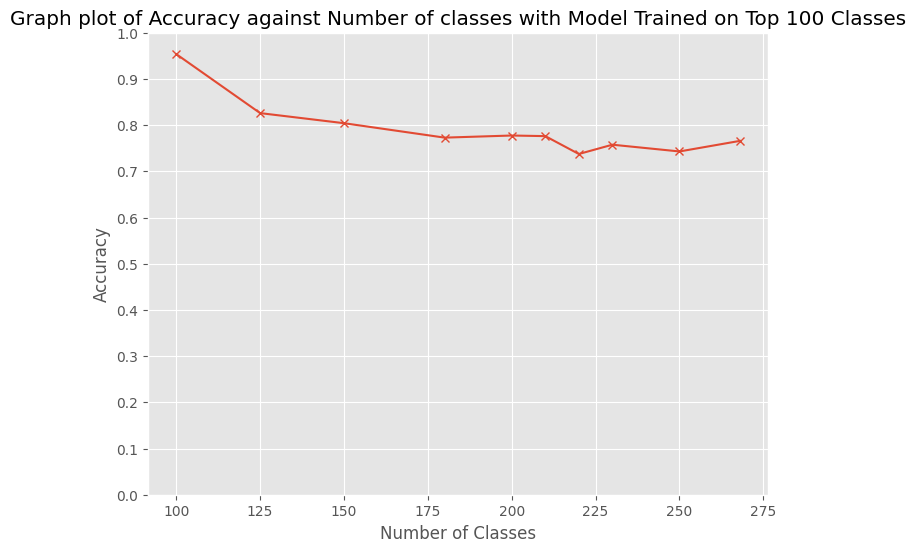

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, acc_scale100, marker='x')
ax.set_title("Graph plot of Accuracy against Number of classes with Model Trained on Top 100 Classes")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Classes')
ax.yaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_ylim(bottom=0)
plt.show()

In [ ]:
wandb.log({"Plot of Accuracy against Number of classes with Model Trained on Top 100 Classes": fig})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



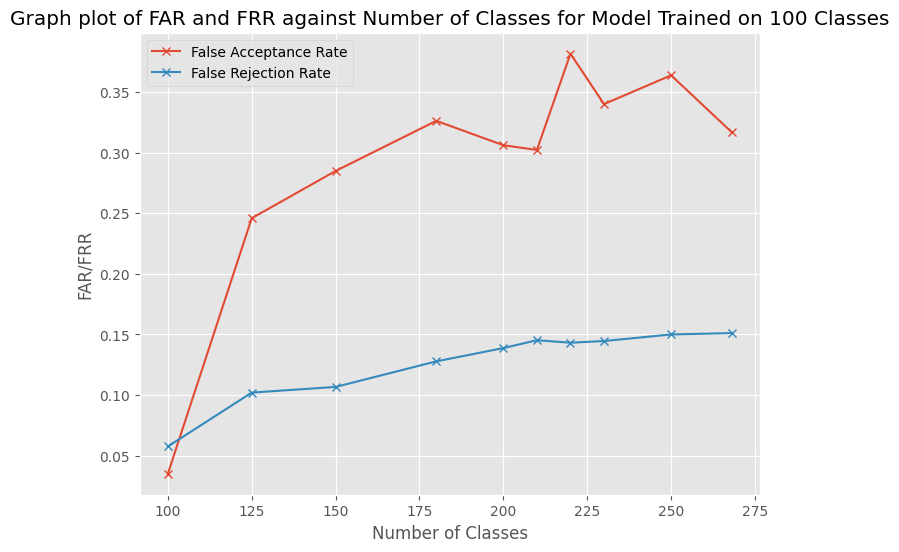

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, fars_100, label = 'False Acceptance Rate', marker='x')
ax.plot(new_classes, frrs_100, label = 'False Rejection Rate', marker='x')
ax.set_title("Graph plot of FAR and FRR against Number of Classes for Model Trained on 100 Classes")
ax.set_xlabel('Number of Classes')
ax.set_ylabel('FAR/FRR')
ax.legend()
plt.show()

In [ ]:
wandb.log({"FAR/FRR Metrics": wandb.Image(fig)})

## Training on 180 Classes

In [ ]:
idx_train = np.where(np.in1d(labels_train, unique[:180]))
idx_valid = np.where(np.in1d(labels_valid, unique[:180]))
idx_test = np.where(np.in1d(labels_test, unique[:180]))

x_train = train.copy()[idx_train]
y_train = labels_train.copy()[idx_train]
x_valid = valid.copy()[idx_valid]
y_valid = labels_valid.copy()[idx_valid]
x_test = test.copy()[idx_test]
y_test = labels_test.copy()[idx_test]


In [ ]:
# create training+test positive and negative pairs
cattle_indices = [np.where(y_train == i)[0] for i in unique[:180]]
tr_pairs, tr_y = create_pairs(x_train, cattle_indices, 180)
cattle_indices = [np.where(y_valid == i)[0] for i in unique[:180]]
tv_pairs, tv_y = create_pairs(x_valid, cattle_indices, 180)
tv_pairs.shape

(2520, 2, 50, 50)

In [ ]:
run  = wandb.init(
    # set the wandb project where this run will be logged
    name = "final-180",
    project="capstone-scalability",
    reinit = True,

    # track hyperparameters and run metadata
    config=config
)

Average Training time per epoch (100),▁
accuracy,▁▅▆▇▇▇▇█████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇█▆███▇█████████▇█████████▇█▇██▇▇██
val_loss,█▃▂▂▂▂▂▃▁▂▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▂▁▁
Average Training time per epoch (100),1.4071
accuracy,0.9867
best_epoch,73
best_val_loss,0.02588
epoch,79


In [ ]:
checkpoint = ModelCheckpoint('model-best180.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callback = TimeHistory()

# Add the checkpoint to the list of callbacks
callbacks_list = [checkpoint, WandbCallback(save_model=True), time_callback]

In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model_180 = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model_180.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model_180.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y.astype(np.float32), # why float32
          batch_size=config["batch_size"], # original is 128
          epochs=epochs,
          validation_data=([tv_pairs[:, 0], tv_pairs[:, 1]], tv_y.astype(np.float32)), callbacks=callbacks_list) # why float32


# compute final accuracy on training and validation sets using the best model
model= load_model('model-best180.h5', custom_objects={'contrastive_loss': contrastive_loss, })
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_tv = model.predict([tv_pairs[:, 0], tv_pairs[:, 1]])
tv_acc = compute_accuracy(tv_y, y_pred_tv)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on val set: %0.2f%%' % (100 * tv_acc))

Epoch 1/80
330/338 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.6355
Epoch 1: val_loss improved from inf to 0.16334, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 5s 13ms/step - loss: 0.2187 - accuracy: 0.6375 - val_loss: 0.1633 - val_accuracy: 0.7474
Epoch 2/80
332/338 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.7739
Epoch 2: val_loss improved from 0.16334 to 0.11662, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.1619 - accuracy: 0.7734 - val_loss: 0.1166 - val_accuracy: 0.8395
Epoch 3/80
330/338 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.8164
Epoch 3: val_loss improved from 0.11662 to 0.10816, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.1394 - accuracy: 0.8171 - val_loss: 0.1082 - val_accuracy: 0.8534
Epoch 4/80
336/338 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.8445
Epoch 4: val_loss improved from 0.10816 to 0.10031, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 3s 10ms/step - loss: 0.1220 - accuracy: 0.8439 - val_loss: 0.1003 - val_accuracy: 0.8784
Epoch 5/80
336/338 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.8614
Epoch 5: val_loss improved from 0.10031 to 0.08378, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.1105 - accuracy: 0.8615 - val_loss: 0.0838 - val_accuracy: 0.9073
Epoch 6/80
329/338 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.8774
Epoch 6: val_loss improved from 0.08378 to 0.07865, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 10ms/step - loss: 0.1015 - accuracy: 0.8772 - val_loss: 0.0786 - val_accuracy: 0.9037
Epoch 7/80
338/338 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.8879
Epoch 7: val_loss did not improve from 0.07865
338/338 [==============================] - 2s 6ms/step - loss: 0.0942 - accuracy: 0.8879 - val_loss: 0.0950 - val_accuracy: 0.8801
Epoch 8/80
331/338 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.8990
Epoch 8: val_loss improved from 0.07865 to 0.07244, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0868 - accuracy: 0.8990 - val_loss: 0.0724 - val_accuracy: 0.9177
Epoch 9/80
336/338 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9073
Epoch 9: val_loss did not improve from 0.07244
338/338 [==============================] - 2s 6ms/step - loss: 0.0833 - accuracy: 0.9073 - val_loss: 0.0729 - val_accuracy: 0.9213
Epoch 10/80
330/338 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9128
Epoch 10: val_loss improved from 0.07244 to 0.07009, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 10ms/step - loss: 0.0787 - accuracy: 0.9136 - val_loss: 0.0701 - val_accuracy: 0.9185
Epoch 11/80
333/338 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9165
Epoch 11: val_loss did not improve from 0.07009
338/338 [==============================] - 2s 6ms/step - loss: 0.0757 - accuracy: 0.9165 - val_loss: 0.1038 - val_accuracy: 0.8571
Epoch 12/80
338/338 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9247
Epoch 12: val_loss did not improve from 0.07009
338/338 [==============================] - 2s 6ms/step - loss: 0.0714 - accuracy: 0.9247 - val_loss: 0.0735 - val_accuracy: 0.9077
Epoch 13/80
331/338 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9262
Epoch 13: val_loss improved from 0.07009 to 0.06508, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 13ms/step - loss: 0.0685 - accuracy: 0.9270 - val_loss: 0.0651 - val_accuracy: 0.9288
Epoch 14/80
335/338 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9292
Epoch 14: val_loss improved from 0.06508 to 0.06334, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0663 - accuracy: 0.9293 - val_loss: 0.0633 - val_accuracy: 0.9221
Epoch 15/80
335/338 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9331
Epoch 15: val_loss did not improve from 0.06334
338/338 [==============================] - 2s 6ms/step - loss: 0.0636 - accuracy: 0.9331 - val_loss: 0.0730 - val_accuracy: 0.9043
Epoch 16/80
329/338 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9372
Epoch 16: val_loss improved from 0.06334 to 0.06309, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0620 - accuracy: 0.9372 - val_loss: 0.0631 - val_accuracy: 0.9284
Epoch 17/80
330/338 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9414
Epoch 17: val_loss improved from 0.06309 to 0.06261, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0591 - accuracy: 0.9408 - val_loss: 0.0626 - val_accuracy: 0.9272
Epoch 18/80
335/338 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9413
Epoch 18: val_loss improved from 0.06261 to 0.06235, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0576 - accuracy: 0.9411 - val_loss: 0.0624 - val_accuracy: 0.9300
Epoch 19/80
332/338 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9445
Epoch 19: val_loss did not improve from 0.06235
338/338 [==============================] - 2s 6ms/step - loss: 0.0548 - accuracy: 0.9441 - val_loss: 0.0787 - val_accuracy: 0.9074
Epoch 20/80
330/338 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9465
Epoch 20: val_loss did not improve from 0.06235
338/338 [==============================] - 2s 6ms/step - loss: 0.0536 - accuracy: 0.9460 - val_loss: 0.0747 - val_accuracy: 0.9122
Epoch 21/80
336/338 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9482
Epoch 21: val_loss did not improve from 0.06235
338/338 [==============================] - 2s 6ms/step - loss: 0.0524 - accuracy: 0.9483 - val_loss: 0.0647 - val_accuracy: 0.9248
Epoch 22/80
332/338 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0504 - accuracy: 0.9520 - val_loss: 0.0602 - val_accuracy: 0.9237
Epoch 23/80
336/338 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9525
Epoch 23: val_loss did not improve from 0.06016
338/338 [==============================] - 2s 7ms/step - loss: 0.0485 - accuracy: 0.9528 - val_loss: 0.0610 - val_accuracy: 0.9221
Epoch 24/80
338/338 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9550
Epoch 24: val_loss improved from 0.06016 to 0.05166, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0472 - accuracy: 0.9550 - val_loss: 0.0517 - val_accuracy: 0.9391
Epoch 25/80
331/338 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9577
Epoch 25: val_loss did not improve from 0.05166
338/338 [==============================] - 2s 6ms/step - loss: 0.0451 - accuracy: 0.9575 - val_loss: 0.0618 - val_accuracy: 0.9209
Epoch 26/80
337/338 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9573
Epoch 26: val_loss did not improve from 0.05166
338/338 [==============================] - 2s 6ms/step - loss: 0.0453 - accuracy: 0.9573 - val_loss: 0.0610 - val_accuracy: 0.9284
Epoch 27/80
337/338 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9600
Epoch 27: val_loss did not improve from 0.05166
338/338 [==============================] - 2s 6ms/step - loss: 0.0426 - accuracy: 0.9600 - val_loss: 0.0633 - val_accuracy: 0.9241
Epoch 28/80
338/338 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 12ms/step - loss: 0.0395 - accuracy: 0.9650 - val_loss: 0.0490 - val_accuracy: 0.9509
Epoch 31/80
331/338 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9656
Epoch 31: val_loss did not improve from 0.04904
338/338 [==============================] - 2s 6ms/step - loss: 0.0382 - accuracy: 0.9660 - val_loss: 0.0729 - val_accuracy: 0.9102
Epoch 32/80
335/338 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9657
Epoch 32: val_loss improved from 0.04904 to 0.04498, saving model to model-best180.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 11ms/step - loss: 0.0383 - accuracy: 0.9659 - val_loss: 0.0450 - val_accuracy: 0.9513
Epoch 33/80
332/338 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9651
Epoch 33: val_loss did not improve from 0.04498
338/338 [==============================] - 2s 7ms/step - loss: 0.0377 - accuracy: 0.9653 - val_loss: 0.0499 - val_accuracy: 0.9458
Epoch 34/80
335/338 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9658
Epoch 34: val_loss did not improve from 0.04498
338/338 [==============================] - 2s 6ms/step - loss: 0.0367 - accuracy: 0.9653 - val_loss: 0.0608 - val_accuracy: 0.9284
Epoch 35/80
330/338 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9688
Epoch 35: val_loss did not improve from 0.04498
338/338 [==============================] - 2s 6ms/step - loss: 0.0354 - accuracy: 0.9688 - val_loss: 0.0598 - val_accuracy: 0.9256
Epoch 36/80
333/338 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_011934-1wdmqmcu/files/model-best)... Done. 0.0s


338/338 [==============================] - 4s 12ms/step - loss: 0.0321 - accuracy: 0.9734 - val_loss: 0.0430 - val_accuracy: 0.9537
Epoch 40/80
334/338 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9732
Epoch 40: val_loss did not improve from 0.04299
338/338 [==============================] - 2s 7ms/step - loss: 0.0314 - accuracy: 0.9733 - val_loss: 0.0444 - val_accuracy: 0.9529
Epoch 41/80
335/338 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9701
Epoch 41: val_loss did not improve from 0.04299
338/338 [==============================] - 2s 6ms/step - loss: 0.0328 - accuracy: 0.9701 - val_loss: 0.0439 - val_accuracy: 0.9458
Epoch 42/80
334/338 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9748
Epoch 42: val_loss did not improve from 0.04299
338/338 [==============================] - 2s 6ms/step - loss: 0.0300 - accuracy: 0.9749 - val_loss: 0.0816 - val_accuracy: 0.8912
Epoch 43/80
333/338 [===================

In [ ]:
times_epoch = time_callback.times
wandb.log({f'Average Training time per epoch (180)': round(np.mean(times_epoch), 4)})

In [ ]:
new_classes = [180, 200, 210, 220, 230, 250, 268] # test set of classes to consider
acc_scale180 = []
fars_180 = []
frrs_180 = []

for i in new_classes:
  idx_test_scale = np.where(np.in1d(labels_test, unique[:i]))
  scale_ytest = labels_test.copy()[idx_test_scale]
  scale_xtest = test.copy()[idx_test_scale]
  cattle_indices = [np.where(scale_ytest == i)[0] for i in unique[:i]]
  te_pairs, te_y = create_pairs(scale_xtest, cattle_indices, i)
  pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  far, frr = bio_metrics(pred_te, te_y)
  fars_180.append(far)
  frrs_180.append(frr)
  comp_acc = compute_accuracy(te_y, pred_te)
  acc_scale180.append(comp_acc)

67/67 [==============================] - 0s 2ms/step


In [ ]:
# log accuracies for training on 180 classes
acc_tab = {'Test Accuracy': acc_scale180, 'Number of Classes': new_classes, 'Training Accuracy': tr_acc,\
           'Training time per epoch (seconds)': round(np.mean(times_epoch), 4)}
acc_tab = pd.DataFrame(acc_tab)
wandb.log({"Scaling Metrics for Training on 180 classes": wandb.Table(data=acc_tab, columns = \
["Test Accuracy", "Number of Classes", "Training Accuracy", 'Training time per epoch (seconds)'])})

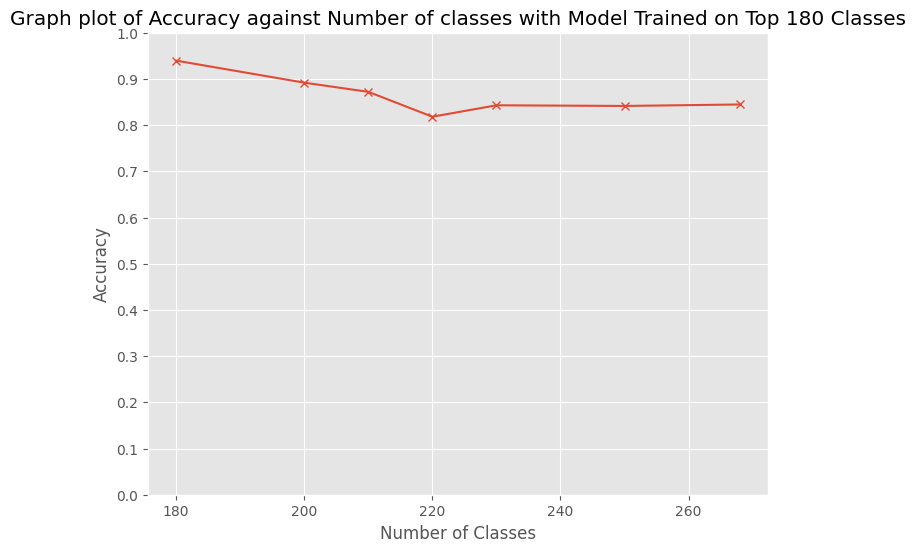

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, acc_scale180, marker='x')
ax.set_title("Graph plot of Accuracy against Number of classes with Model Trained on Top 180 Classes")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Classes')
ax.yaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_ylim(bottom=0)
plt.show()

In [ ]:
wandb.log({"Plot of Accuracy against Number of classes with Model Trained on Top 180 Classes": fig})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



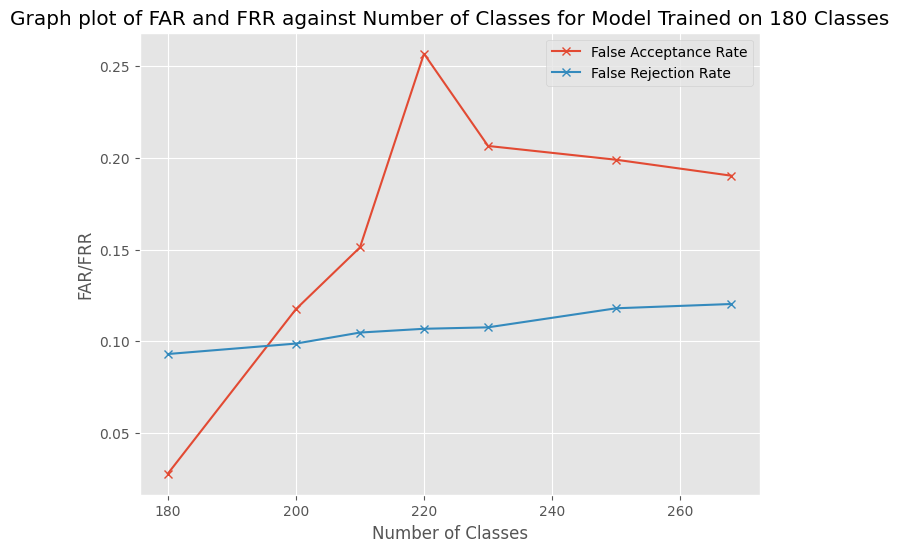

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, fars_180, label = 'False Acceptance Rate', marker='x')
ax.plot(new_classes, frrs_180, label = 'False Rejection Rate', marker='x')
ax.set_title("Graph plot of FAR and FRR against Number of Classes for Model Trained on 180 Classes")
ax.set_xlabel('Number of Classes')
ax.set_ylabel('FAR/FRR')
ax.legend()
plt.show()

## Training on 210 Classes

In [ ]:
idx_train = np.where(np.in1d(labels_train, unique[:210]))
idx_valid = np.where(np.in1d(labels_valid, unique[:210]))
idx_test = np.where(np.in1d(labels_test, unique[:210]))

x_train = train.copy()[idx_train]
y_train = labels_train.copy()[idx_train]
x_valid = valid.copy()[idx_valid]
y_valid = labels_valid.copy()[idx_valid]
x_test = test.copy()[idx_test]
y_test = labels_test.copy()[idx_test]


In [ ]:
# create training+test positive and negative pairs
cattle_indices = [np.where(y_train == i)[0] for i in unique[:210]]
tr_pairs, tr_y = create_pairs(x_train, cattle_indices, 210)
cattle_indices = [np.where(y_valid == i)[0] for i in unique[:210]]
tv_pairs, tv_y = create_pairs(x_valid, cattle_indices, 210)
tv_pairs.shape

(2940, 2, 50, 50)

In [ ]:
run  = wandb.init(
    # set the wandb project where this run will be logged
    name = "final-210",
    project="capstone-scalability",
    reinit = True,

    # track hyperparameters and run metadata
    config=config
)

Average Training time per epoch (180),▁
accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▅▇▆▇▆▇▇▇▇▇▇█▇████▇█▆▇▇█▇▇█▇██▆█████
val_loss,█▅▃▄▃▅▂▃▂▃▂▂▂▂▂▃▁▂▁▁▁▁▂▁▃▂▂▁▂▂▁▂▁▁▄▁▁▁▁▁
Average Training time per epoch (180),2.5129
accuracy,0.98447
best_epoch,38
best_val_loss,0.04299
epoch,79


In [ ]:
checkpoint = ModelCheckpoint('model-best210.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callback = TimeHistory()

# Add the checkpoint to the list of callbacks
callbacks_list = [checkpoint, WandbCallback(save_model=True), time_callback]

In [ ]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model_210 = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model_210.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model_210.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y.astype(np.float32), # why float32
          batch_size=config["batch_size"], # original is 128
          epochs=epochs,
          validation_data=([tv_pairs[:, 0], tv_pairs[:, 1]], tv_y.astype(np.float32)), callbacks=callbacks_list) # why float32


# compute final accuracy on training and validation sets using the best model
model= load_model('model-best210.h5', custom_objects={'contrastive_loss': contrastive_loss, })
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_tv = model.predict([tv_pairs[:, 0], tv_pairs[:, 1]])
tv_acc = compute_accuracy(tv_y, y_pred_tv)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on val set: %0.2f%%' % (100 * tv_acc))

Epoch 1/80
389/394 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.6575
Epoch 1: val_loss improved from inf to 0.13521, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 5s 11ms/step - loss: 0.2102 - accuracy: 0.6584 - val_loss: 0.1352 - val_accuracy: 0.8086
Epoch 2/80
386/394 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.8086
Epoch 2: val_loss improved from 0.13521 to 0.10388, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.1442 - accuracy: 0.8088 - val_loss: 0.1039 - val_accuracy: 0.8651
Epoch 3/80
392/394 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.8461
Epoch 3: val_loss improved from 0.10388 to 0.08920, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 5s 12ms/step - loss: 0.1209 - accuracy: 0.8462 - val_loss: 0.0892 - val_accuracy: 0.8865
Epoch 4/80
389/394 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.8679
Epoch 4: val_loss improved from 0.08920 to 0.08282, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 5s 12ms/step - loss: 0.1074 - accuracy: 0.8682 - val_loss: 0.0828 - val_accuracy: 0.8932
Epoch 5/80
388/394 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.8792
Epoch 5: val_loss did not improve from 0.08282
394/394 [==============================] - 2s 6ms/step - loss: 0.0978 - accuracy: 0.8790 - val_loss: 0.0919 - val_accuracy: 0.8821
Epoch 6/80
393/394 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.8893
Epoch 6: val_loss improved from 0.08282 to 0.07253, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0917 - accuracy: 0.8891 - val_loss: 0.0725 - val_accuracy: 0.9096
Epoch 7/80
393/394 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.8950
Epoch 7: val_loss improved from 0.07253 to 0.07045, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 11ms/step - loss: 0.0873 - accuracy: 0.8950 - val_loss: 0.0705 - val_accuracy: 0.9158
Epoch 8/80
394/394 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9034
Epoch 8: val_loss did not improve from 0.07045
394/394 [==============================] - 2s 6ms/step - loss: 0.0822 - accuracy: 0.9034 - val_loss: 0.0733 - val_accuracy: 0.9113
Epoch 9/80
392/394 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9093
Epoch 9: val_loss improved from 0.07045 to 0.06828, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0788 - accuracy: 0.9094 - val_loss: 0.0683 - val_accuracy: 0.9137
Epoch 10/80
392/394 [============================>.] - ETA: 0s - loss: 0.0752 - accuracy: 0.9146
Epoch 10: val_loss did not improve from 0.06828
394/394 [==============================] - 3s 6ms/step - loss: 0.0752 - accuracy: 0.9146 - val_loss: 0.0689 - val_accuracy: 0.9161
Epoch 11/80
393/394 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9183
Epoch 11: val_loss improved from 0.06828 to 0.06237, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 11ms/step - loss: 0.0722 - accuracy: 0.9183 - val_loss: 0.0624 - val_accuracy: 0.9215
Epoch 12/80
390/394 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9220
Epoch 12: val_loss did not improve from 0.06237
394/394 [==============================] - 2s 6ms/step - loss: 0.0689 - accuracy: 0.9219 - val_loss: 0.0674 - val_accuracy: 0.9139
Epoch 13/80
391/394 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9259
Epoch 13: val_loss improved from 0.06237 to 0.06043, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0669 - accuracy: 0.9260 - val_loss: 0.0604 - val_accuracy: 0.9276
Epoch 14/80
394/394 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9308
Epoch 14: val_loss did not improve from 0.06043
394/394 [==============================] - 3s 6ms/step - loss: 0.0646 - accuracy: 0.9308 - val_loss: 0.0703 - val_accuracy: 0.9137
Epoch 15/80
394/394 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9327
Epoch 15: val_loss did not improve from 0.06043
394/394 [==============================] - 3s 6ms/step - loss: 0.0632 - accuracy: 0.9327 - val_loss: 0.0687 - val_accuracy: 0.9205
Epoch 16/80
391/394 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9348
Epoch 16: val_loss did not improve from 0.06043
394/394 [==============================] - 2s 6ms/step - loss: 0.0612 - accuracy: 0.9349 - val_loss: 0.0615 - val_accuracy: 0.9266
Epoch 17/80
386/394 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0584 - accuracy: 0.9379 - val_loss: 0.0546 - val_accuracy: 0.9372
Epoch 19/80
389/394 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9414
Epoch 19: val_loss improved from 0.05456 to 0.05402, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0566 - accuracy: 0.9417 - val_loss: 0.0540 - val_accuracy: 0.9361
Epoch 20/80
387/394 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9430
Epoch 20: val_loss did not improve from 0.05402
394/394 [==============================] - 3s 7ms/step - loss: 0.0546 - accuracy: 0.9427 - val_loss: 0.0548 - val_accuracy: 0.9365
Epoch 21/80
387/394 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9478
Epoch 21: val_loss did not improve from 0.05402
394/394 [==============================] - 2s 6ms/step - loss: 0.0525 - accuracy: 0.9481 - val_loss: 0.0602 - val_accuracy: 0.9253
Epoch 22/80
393/394 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9470
Epoch 22: val_loss did not improve from 0.05402
394/394 [==============================] - 2s 6ms/step - loss: 0.0520 - accuracy: 0.9469 - val_loss: 0.0573 - val_accuracy: 0.9361
Epoch 23/80
393/394 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 5s 11ms/step - loss: 0.0493 - accuracy: 0.9498 - val_loss: 0.0516 - val_accuracy: 0.9416
Epoch 25/80
389/394 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9526
Epoch 25: val_loss improved from 0.05162 to 0.04977, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0479 - accuracy: 0.9525 - val_loss: 0.0498 - val_accuracy: 0.9458
Epoch 26/80
388/394 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9538
Epoch 26: val_loss did not improve from 0.04977
394/394 [==============================] - 2s 6ms/step - loss: 0.0461 - accuracy: 0.9537 - val_loss: 0.0573 - val_accuracy: 0.9293
Epoch 27/80
391/394 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9572
Epoch 27: val_loss improved from 0.04977 to 0.04963, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0452 - accuracy: 0.9570 - val_loss: 0.0496 - val_accuracy: 0.9429
Epoch 28/80
387/394 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9574
Epoch 28: val_loss did not improve from 0.04963
394/394 [==============================] - 2s 6ms/step - loss: 0.0445 - accuracy: 0.9574 - val_loss: 0.0575 - val_accuracy: 0.9319
Epoch 29/80
391/394 [============================>.] - ETA: 0s - loss: 0.0433 - accuracy: 0.9576
Epoch 29: val_loss improved from 0.04963 to 0.04814, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0432 - accuracy: 0.9578 - val_loss: 0.0481 - val_accuracy: 0.9443
Epoch 30/80
394/394 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9590
Epoch 30: val_loss did not improve from 0.04814
394/394 [==============================] - 3s 6ms/step - loss: 0.0426 - accuracy: 0.9590 - val_loss: 0.0612 - val_accuracy: 0.9289
Epoch 31/80
387/394 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9616
Epoch 31: val_loss did not improve from 0.04814
394/394 [==============================] - 2s 6ms/step - loss: 0.0408 - accuracy: 0.9613 - val_loss: 0.0534 - val_accuracy: 0.9411
Epoch 32/80
393/394 [============================>.] - ETA: 0s - loss: 0.0403 - accuracy: 0.9626
Epoch 32: val_loss did not improve from 0.04814
394/394 [==============================] - 2s 6ms/step - loss: 0.0403 - accuracy: 0.9627 - val_loss: 0.0528 - val_accuracy: 0.9392
Epoch 33/80
390/394 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0375 - accuracy: 0.9633 - val_loss: 0.0476 - val_accuracy: 0.9463
Epoch 37/80
392/394 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9664
Epoch 37: val_loss did not improve from 0.04762
394/394 [==============================] - 2s 6ms/step - loss: 0.0359 - accuracy: 0.9665 - val_loss: 0.0553 - val_accuracy: 0.9368
Epoch 38/80
388/394 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9671
Epoch 38: val_loss did not improve from 0.04762
394/394 [==============================] - 2s 6ms/step - loss: 0.0354 - accuracy: 0.9670 - val_loss: 0.0486 - val_accuracy: 0.9467
Epoch 39/80
386/394 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9669
Epoch 39: val_loss did not improve from 0.04762
394/394 [==============================] - 2s 6ms/step - loss: 0.0363 - accuracy: 0.9667 - val_loss: 0.0541 - val_accuracy: 0.9365
Epoch 40/80
393/394 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0332 - accuracy: 0.9703 - val_loss: 0.0464 - val_accuracy: 0.9480
Epoch 41/80
393/394 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9708
Epoch 41: val_loss did not improve from 0.04644
394/394 [==============================] - 2s 6ms/step - loss: 0.0330 - accuracy: 0.9709 - val_loss: 0.0493 - val_accuracy: 0.9460
Epoch 42/80
389/394 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9724
Epoch 42: val_loss improved from 0.04644 to 0.04418, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0325 - accuracy: 0.9721 - val_loss: 0.0442 - val_accuracy: 0.9494
Epoch 43/80
385/394 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9728
Epoch 43: val_loss did not improve from 0.04418
394/394 [==============================] - 2s 6ms/step - loss: 0.0305 - accuracy: 0.9732 - val_loss: 0.0480 - val_accuracy: 0.9470
Epoch 44/80
392/394 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9711
Epoch 44: val_loss did not improve from 0.04418
394/394 [==============================] - 3s 6ms/step - loss: 0.0314 - accuracy: 0.9713 - val_loss: 0.0482 - val_accuracy: 0.9442
Epoch 45/80
388/394 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9748
Epoch 45: val_loss did not improve from 0.04418
394/394 [==============================] - 3s 7ms/step - loss: 0.0294 - accuracy: 0.9747 - val_loss: 0.0568 - val_accuracy: 0.9313
Epoch 46/80
385/394 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 10ms/step - loss: 0.0298 - accuracy: 0.9741 - val_loss: 0.0442 - val_accuracy: 0.9484
Epoch 47/80
394/394 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9744
Epoch 47: val_loss did not improve from 0.04416
394/394 [==============================] - 2s 6ms/step - loss: 0.0286 - accuracy: 0.9744 - val_loss: 0.0471 - val_accuracy: 0.9402
Epoch 48/80
389/394 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9741
Epoch 48: val_loss improved from 0.04416 to 0.04219, saving model to model-best210.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


394/394 [==============================] - 4s 11ms/step - loss: 0.0288 - accuracy: 0.9740 - val_loss: 0.0422 - val_accuracy: 0.9524
Epoch 49/80
385/394 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9753
Epoch 49: val_loss did not improve from 0.04219
394/394 [==============================] - 2s 6ms/step - loss: 0.0279 - accuracy: 0.9750 - val_loss: 0.0506 - val_accuracy: 0.9419
Epoch 50/80
385/394 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9753
Epoch 50: val_loss did not improve from 0.04219
394/394 [==============================] - 2s 6ms/step - loss: 0.0271 - accuracy: 0.9751 - val_loss: 0.0458 - val_accuracy: 0.9457
Epoch 51/80
387/394 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9771
Epoch 51: val_loss did not improve from 0.04219
394/394 [==============================] - 2s 6ms/step - loss: 0.0266 - accuracy: 0.9768 - val_loss: 0.0502 - val_accuracy: 0.9367
Epoch 52/80
387/394 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20231201_012317-xnkex1cl/files/model-best)... Done. 0.0s


92/92 [==============================] - 0s 2ms/step
* Accuracy on training set: 99.51%
* Accuracy on val set: 95.07%


In [ ]:
times_epoch = time_callback.times
wandb.log({f'Average Training time per epoch (210)': round(np.mean(times_epoch), 4)})

In [ ]:
new_classes = [210, 220, 230, 250, 268] # test set of classes to consider
acc_scale210 = []
fars_210 = []
frrs_210 = []

for i in new_classes:
  idx_test_scale = np.where(np.in1d(labels_test, unique[:i]))
  scale_ytest = labels_test.copy()[idx_test_scale]
  scale_xtest = test.copy()[idx_test_scale]
  cattle_indices = [np.where(scale_ytest == i)[0] for i in unique[:i]]
  te_pairs, te_y = create_pairs(scale_xtest, cattle_indices, i)
  pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  far, frr = bio_metrics(pred_te, te_y)
  fars_210.append(far)
  frrs_210.append(frr)
  comp_acc = compute_accuracy(te_y, pred_te)
  acc_scale210.append(comp_acc)

67/67 [==============================] - 0s 2ms/step


In [ ]:
# log accuracies for training on 210 classes
acc_tab = {'Test Accuracy': acc_scale210, 'Number of Classes': new_classes, 'Training Accuracy': tr_acc,\
           'Training time per epoch (seconds)': round(np.mean(times_epoch), 4)}
acc_tab = pd.DataFrame(acc_tab)
wandb.log({"Scaling Metrics for Training on 210 classes": wandb.Table(data=acc_tab, columns = \
["Test Accuracy", "Number of Classes", "Training Accuracy", 'Training time per epoch (seconds)'])})

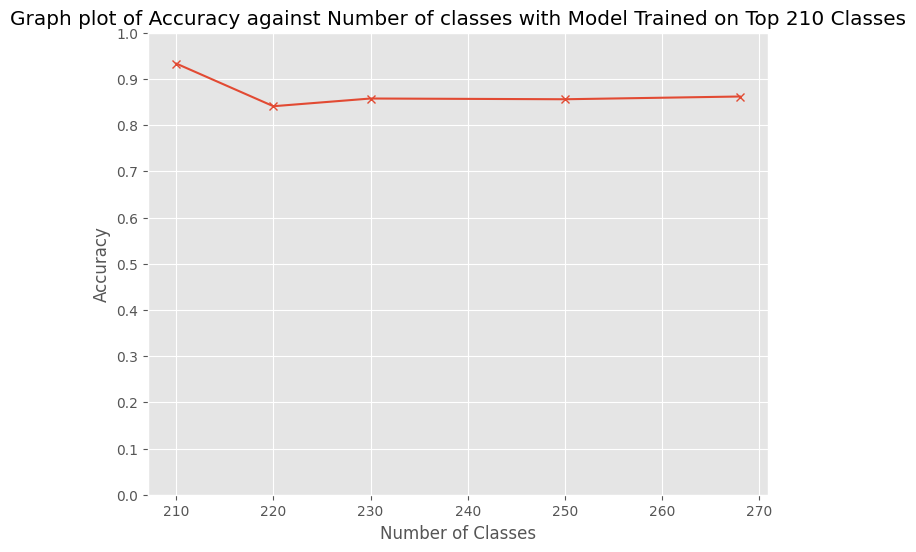

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, acc_scale210, marker='x')
ax.set_title("Graph plot of Accuracy against Number of classes with Model Trained on Top 210 Classes")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Classes')
ax.yaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_ylim(bottom=0)
plt.show()

In [ ]:
wandb.log({"Plot of Accuracy against Number of classes with Model Trained on Top 210 Classes": fig})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



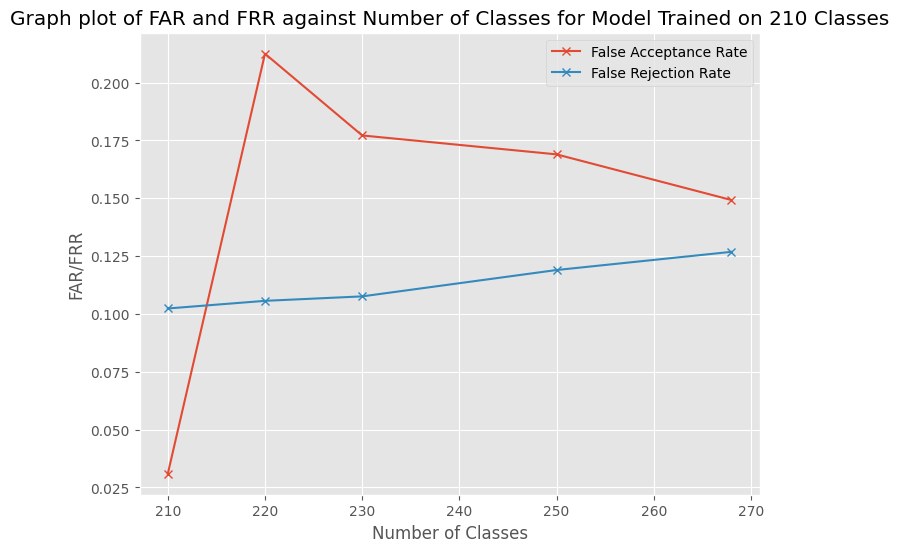

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(new_classes, fars_210, label = 'False Acceptance Rate', marker='x')
ax.plot(new_classes, frrs_210, label = 'False Rejection Rate', marker='x')
ax.set_title("Graph plot of FAR and FRR against Number of Classes for Model Trained on 210 Classes")
ax.set_xlabel('Number of Classes')
ax.set_ylabel('FAR/FRR')
ax.legend()
plt.show()

In [ ]:
wandb.log({"FAR/FRR Metrics": wandb.Image(fig)})

In [ ]:
run.finish()

Average Training time per epoch (210),▁
accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇▇▆▇▇▆████▇█▇▇██▇▇█▇█▇▆▇███▇██▇▇██
val_loss,█▅▅▃▃▃▂▃▃▂▂▃▂▂▁▂▂▂▂▂▂▁▂▁▂▂▁▂▃▂▁▁▁▁▁▁▂▂▁▁
Average Training time per epoch (210),2.8663
accuracy,0.98065
best_epoch,79
best_val_loss,0.04152
epoch,79
